<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C2/W4/ungraded_lab/C2_W4_Lab_1_multi_class_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Garbage Class Classifier

In this lab, you will look at how to build a model to distinguish between more than two classes. The code will be similar to the ones you've been using before with a few key changes in the model and in the training parameters. Let's dive in!


## Download and Prepare the Dataset

You will be using the [Garbage Classification dataset](https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification), a gallery of Garbage images contains 6 classifications: cardboard (393), glass (491), metal (400), paper(584), plastic (472) and trash(127).

In [1]:
import zipfile

# Extract the archive
local_zip = './archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/all')
zip_ref.close()


In [2]:
#remove the trash class
import shutil
path = './tmp/all/Garbage classification/Garbage classification/trash'

try:
   shutil.rmtree(path)
   print("directory is removed successfully")
except OSError as x:
   print("Error occured: %s : %s" % (path, x.strerror))

directory is removed successfully


In [3]:
import splitfolders # or import splitfolders
#split 
input_folder = "./tmp/all/Garbage classification/Garbage classification"
output = "./tmp/splitted/" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.85, .15)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

As usual, you will assign the directory names into variables and look at the filenames as a sanity check.

In [4]:
import os

base_dir = './tmp/splitted/train'

cardboard_dir = os.path.join(base_dir, 'cardboard')
glass_dir = os.path.join(base_dir, 'glass')
metal_dir = os.path.join(base_dir, 'metal')
paper_dir = os.path.join(base_dir, 'paper')
plastic_dir = os.path.join(base_dir, 'plastic')

print('total training cardboard images:', len(os.listdir(cardboard_dir)))
print('total training glass images:', len(os.listdir(glass_dir)))
print('total training metal images:', len(os.listdir(metal_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training plastic images:', len(os.listdir(plastic_dir)))

cardboard_files = os.listdir(cardboard_dir)
print(cardboard_files[:10])

glass_files = os.listdir(glass_dir)
print(glass_files[:10])

metal_files = os.listdir(metal_dir)
print(metal_files[:10])

paper_files = os.listdir(paper_dir)
print(paper_files[:10])

plastic_files = os.listdir(plastic_dir)
print(plastic_files[:10])

total training cardboard images: 342
total training glass images: 425
total training metal images: 348
total training paper images: 504
total training plastic images: 409
['cardboard1.jpg', 'cardboard10.jpg', 'cardboard100.jpg', 'cardboard102.jpg', 'cardboard103.jpg', 'cardboard104.jpg', 'cardboard105.jpg', 'cardboard106.jpg', 'cardboard107.jpg', 'cardboard108.jpg']
['glass1.jpg', 'glass10.jpg', 'glass100.jpg', 'glass102.jpg', 'glass103.jpg', 'glass104.jpg', 'glass105.jpg', 'glass106.jpg', 'glass107.jpg', 'glass108.jpg']
['metal1.jpg', 'metal10.jpg', 'metal100.jpg', 'metal102.jpg', 'metal103.jpg', 'metal104.jpg', 'metal105.jpg', 'metal106.jpg', 'metal107.jpg', 'metal108.jpg']
['paper1.jpg', 'paper10.jpg', 'paper100.jpg', 'paper101.jpg', 'paper102.jpg', 'paper103.jpg', 'paper105.jpg', 'paper106.jpg', 'paper107.jpg', 'paper108.jpg']
['plastic1.jpg', 'plastic10.jpg', 'plastic100.jpg', 'plastic102.jpg', 'plastic103.jpg', 'plastic104.jpg', 'plastic105.jpg', 'plastic106.jpg', 'plastic107.jpg

You can also inspect some of the images to see the variety in your model inputs.

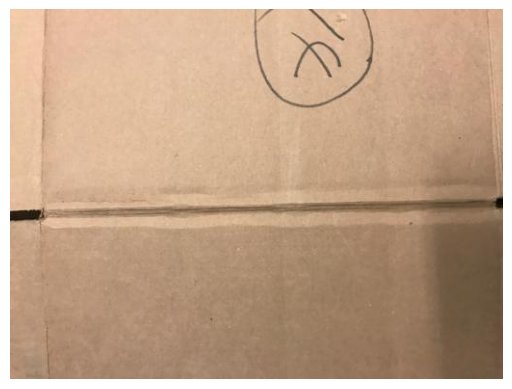

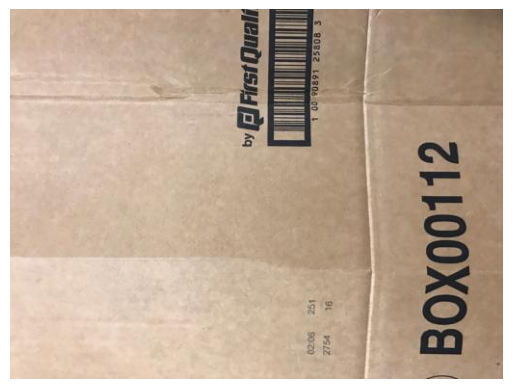

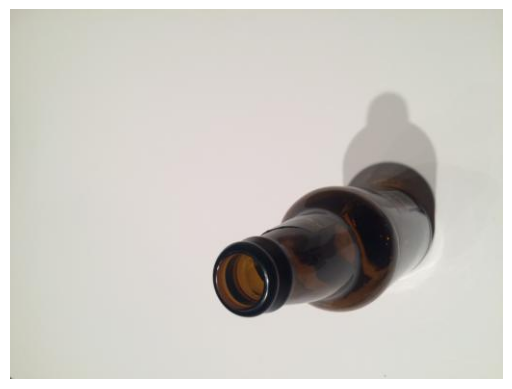

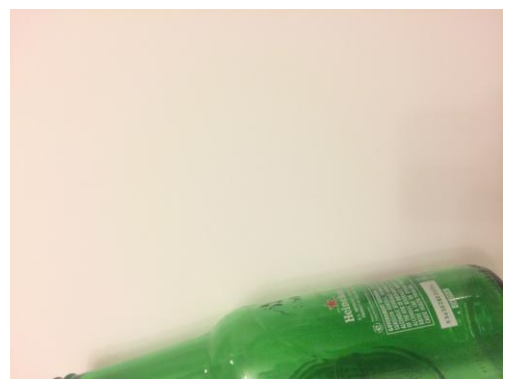

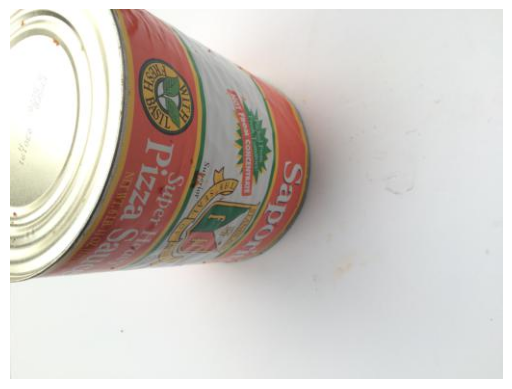

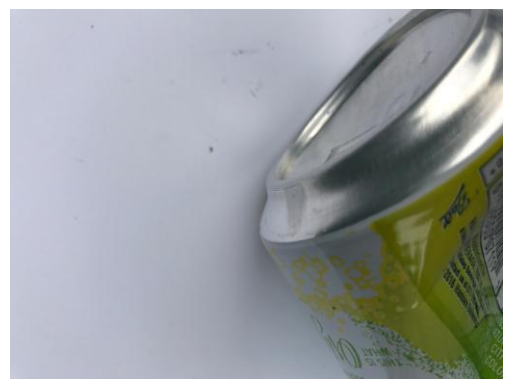

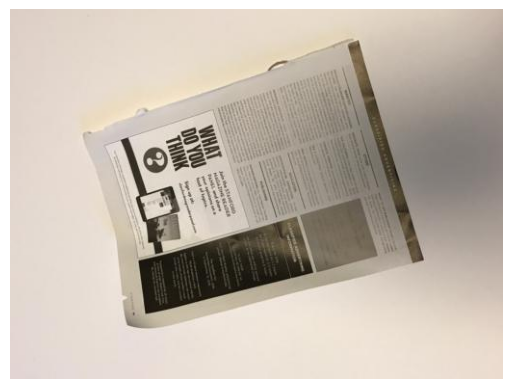

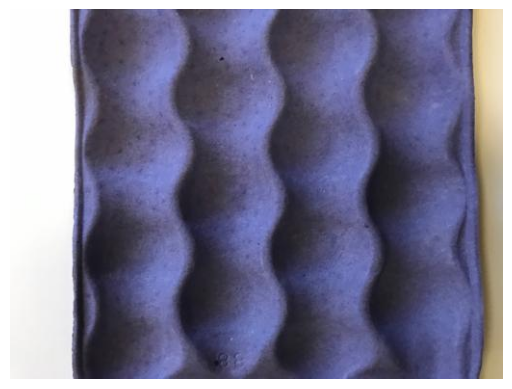

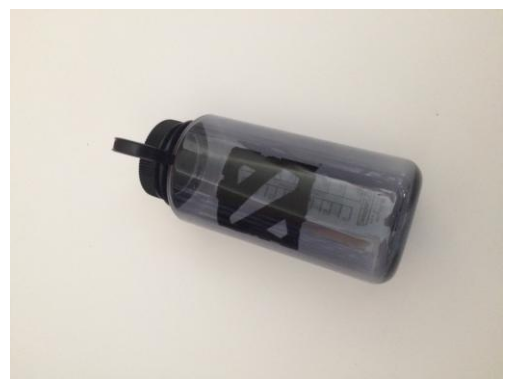

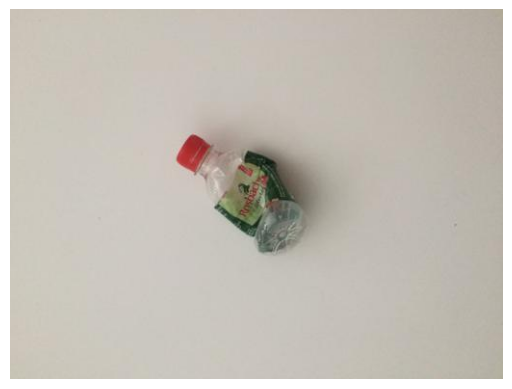

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_cardboard = [os.path.join(cardboard_dir, fname) 
                for fname in cardboard_files[pic_index-2:pic_index]]
next_glass = [os.path.join(glass_dir, fname) 
                for fname in glass_files[pic_index-2:pic_index]]
next_metal = [os.path.join(metal_dir, fname) 
                for fname in metal_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) 
                for fname in paper_files[pic_index-2:pic_index]]
next_plastic = [os.path.join(plastic_dir, fname) 
                for fname in plastic_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_cardboard+next_glass+next_metal+next_paper+next_plastic):
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

## Build the model

You will then build your CNN. You will use 4 convolution layers with 64-64-128-128 filters then append a `Dropout` layer to avoid overfitting and some Dense layers for the classification. The output layer would be a 3-neuron dense layer activated by [Softmax](https://www.tensorflow.org/api_docs/python/tf/nn/softmax). You've seen this in Course 1 when you were training with Fashion MNIST. It scales your output to a set of probabilities that add up to 1. The order of this 3-neuron output would be `paper`-`rock`-`scissors` (e.g. a `[0.8 0.2 0.0]` output means the model is prediciting 80% probability for paper and 20% probability for rock.

You can examine the architecture with `model.summary()` below.

In [6]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dropout (Dropout)           (None, 82944)             0

In [7]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training after reaching 60 percent accuracy

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check accuracy
    if(logs.get('loss') < 0.4):

      # Stop if threshold is met
      print("\nLoss is lower than 0.4 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [8]:
# Set the training parameters
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Prepare the ImageDataGenerator

You will prepare the generators as before. You will set the training set up for data augmentation so it can mimick other poses that the model needs to learn.

In [9]:
from keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = "./tmp/splitted/train"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "./tmp/splitted/val"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)

Found 2028 images belonging to 5 classes.
Found 362 images belonging to 5 classes.


## Train the model and evaluate the results

You will train for 1000 epochs and use callbacks to stop when it reaches the desired accuracy.



In [10]:
# Train the model
history = model.fit(train_generator, epochs=1000, steps_per_epoch=5, validation_data = validation_generator, verbose = 1, validation_steps=3, callbacks=[callbacks])

Epoch 1/1000
5/5 [==============================] - 25s 5s/step - loss: 6.3173 - accuracy: 0.1968 - val_loss: 1.6601 - val_accuracy: 0.1768
Epoch 2/1000
5/5 [==============================] - 16s 4s/step - loss: 1.6133 - accuracy: 0.2364 - val_loss: 1.6087 - val_accuracy: 0.2072
Epoch 3/1000
5/5 [==============================] - 16s 3s/step - loss: 1.6076 - accuracy: 0.2229 - val_loss: 1.6027 - val_accuracy: 0.2210
Epoch 4/1000
5/5 [==============================] - 17s 3s/step - loss: 1.5896 - accuracy: 0.2460 - val_loss: 1.5858 - val_accuracy: 0.2790
Epoch 5/1000
5/5 [==============================] - 16s 3s/step - loss: 1.5859 - accuracy: 0.2365 - val_loss: 1.5973 - val_accuracy: 0.2486
Epoch 6/1000
5/5 [==============================] - 16s 3s/step - loss: 1.5603 - accuracy: 0.2556 - val_loss: 1.5374 - val_accuracy: 0.2901
Epoch 7/1000
5/5 [==============================] - 14s 3s/step - loss: 1.5790 - accuracy: 0.2422 - val_loss: 1.5835 - val_accuracy: 0.3122
Epoch 8/1000
5/5 [==

5/5 [==============================] - 16s 3s/step - loss: 1.3589 - accuracy: 0.4175 - val_loss: 1.2938 - val_accuracy: 0.4475
Epoch 60/1000
5/5 [==============================] - 16s 3s/step - loss: 1.3142 - accuracy: 0.4413 - val_loss: 1.3822 - val_accuracy: 0.4171
Epoch 61/1000
5/5 [==============================] - 15s 3s/step - loss: 1.3323 - accuracy: 0.4238 - val_loss: 1.2720 - val_accuracy: 0.4586
Epoch 62/1000
5/5 [==============================] - 16s 3s/step - loss: 1.3268 - accuracy: 0.4238 - val_loss: 1.2992 - val_accuracy: 0.4917
Epoch 63/1000
5/5 [==============================] - 16s 3s/step - loss: 1.2668 - accuracy: 0.4492 - val_loss: 1.2539 - val_accuracy: 0.4751
Epoch 64/1000
5/5 [==============================] - 14s 3s/step - loss: 1.3839 - accuracy: 0.4012 - val_loss: 1.2268 - val_accuracy: 0.4917
Epoch 65/1000
5/5 [==============================] - 15s 3s/step - loss: 1.3388 - accuracy: 0.4264 - val_loss: 1.3799 - val_accuracy: 0.3867
Epoch 66/1000
5/5 [========

5/5 [==============================] - 16s 3s/step - loss: 1.0216 - accuracy: 0.5667 - val_loss: 1.0243 - val_accuracy: 0.6188
Epoch 118/1000
5/5 [==============================] - 15s 3s/step - loss: 1.0454 - accuracy: 0.5814 - val_loss: 1.0817 - val_accuracy: 0.5773
Epoch 119/1000
5/5 [==============================] - 16s 3s/step - loss: 1.0716 - accuracy: 0.5476 - val_loss: 1.0682 - val_accuracy: 0.5525
Epoch 120/1000
5/5 [==============================] - 15s 3s/step - loss: 1.0004 - accuracy: 0.5667 - val_loss: 1.0207 - val_accuracy: 0.6022
Epoch 121/1000
5/5 [==============================] - 16s 3s/step - loss: 1.0746 - accuracy: 0.5476 - val_loss: 1.0256 - val_accuracy: 0.5884
Epoch 122/1000
5/5 [==============================] - 15s 3s/step - loss: 1.0601 - accuracy: 0.5678 - val_loss: 1.0683 - val_accuracy: 0.5801
Epoch 123/1000
5/5 [==============================] - 15s 3s/step - loss: 0.9898 - accuracy: 0.5857 - val_loss: 1.0606 - val_accuracy: 0.5801
Epoch 124/1000
5/5 [=

Epoch 175/1000
5/5 [==============================] - 15s 3s/step - loss: 0.9171 - accuracy: 0.6531 - val_loss: 0.9177 - val_accuracy: 0.6713
Epoch 176/1000
5/5 [==============================] - 16s 3s/step - loss: 0.9976 - accuracy: 0.5905 - val_loss: 1.0150 - val_accuracy: 0.6133
Epoch 177/1000
5/5 [==============================] - 16s 3s/step - loss: 0.9243 - accuracy: 0.6413 - val_loss: 1.0095 - val_accuracy: 0.6271
Epoch 178/1000
5/5 [==============================] - 15s 3s/step - loss: 0.9972 - accuracy: 0.6318 - val_loss: 0.9165 - val_accuracy: 0.6271
Epoch 179/1000
5/5 [==============================] - 16s 3s/step - loss: 0.8710 - accuracy: 0.6476 - val_loss: 0.9695 - val_accuracy: 0.6657
Epoch 180/1000
5/5 [==============================] - 16s 3s/step - loss: 0.9477 - accuracy: 0.6429 - val_loss: 0.8911 - val_accuracy: 0.6685
Epoch 181/1000
5/5 [==============================] - 16s 3s/step - loss: 0.9072 - accuracy: 0.6524 - val_loss: 0.9138 - val_accuracy: 0.6575
Epoch 

Epoch 233/1000
5/5 [==============================] - 16s 3s/step - loss: 0.7457 - accuracy: 0.7349 - val_loss: 0.8332 - val_accuracy: 0.6823
Epoch 234/1000
5/5 [==============================] - 16s 3s/step - loss: 0.7732 - accuracy: 0.7063 - val_loss: 0.8751 - val_accuracy: 0.6685
Epoch 235/1000
5/5 [==============================] - 17s 3s/step - loss: 0.7558 - accuracy: 0.7143 - val_loss: 0.8147 - val_accuracy: 0.6989
Epoch 236/1000
5/5 [==============================] - 16s 3s/step - loss: 0.8106 - accuracy: 0.7063 - val_loss: 0.8465 - val_accuracy: 0.6878
Epoch 237/1000
5/5 [==============================] - 16s 3s/step - loss: 0.7391 - accuracy: 0.7254 - val_loss: 0.7889 - val_accuracy: 0.7293
Epoch 238/1000
5/5 [==============================] - 15s 3s/step - loss: 0.8110 - accuracy: 0.6899 - val_loss: 0.8329 - val_accuracy: 0.6934
Epoch 239/1000
5/5 [==============================] - 16s 3s/step - loss: 0.8359 - accuracy: 0.6889 - val_loss: 0.8601 - val_accuracy: 0.6851
Epoch 

Epoch 291/1000
5/5 [==============================] - 15s 3s/step - loss: 0.6224 - accuracy: 0.7694 - val_loss: 0.8532 - val_accuracy: 0.6934
Epoch 292/1000
5/5 [==============================] - 16s 3s/step - loss: 0.7231 - accuracy: 0.7206 - val_loss: 0.7875 - val_accuracy: 0.7376
Epoch 293/1000
5/5 [==============================] - 16s 3s/step - loss: 0.7250 - accuracy: 0.7222 - val_loss: 0.7923 - val_accuracy: 0.7155
Epoch 294/1000
5/5 [==============================] - 15s 3s/step - loss: 0.6404 - accuracy: 0.7655 - val_loss: 0.7719 - val_accuracy: 0.7210
Epoch 295/1000
5/5 [==============================] - 17s 3s/step - loss: 0.7659 - accuracy: 0.7270 - val_loss: 0.7831 - val_accuracy: 0.7376
Epoch 296/1000
5/5 [==============================] - 15s 3s/step - loss: 0.7343 - accuracy: 0.7111 - val_loss: 0.7312 - val_accuracy: 0.7541
Epoch 297/1000
5/5 [==============================] - 15s 3s/step - loss: 0.6064 - accuracy: 0.7587 - val_loss: 0.7866 - val_accuracy: 0.7155
Epoch 

Epoch 349/1000
5/5 [==============================] - 15s 3s/step - loss: 0.6261 - accuracy: 0.7539 - val_loss: 0.7551 - val_accuracy: 0.7293
Epoch 350/1000
5/5 [==============================] - 16s 3s/step - loss: 0.6025 - accuracy: 0.7651 - val_loss: 0.6539 - val_accuracy: 0.7624
Epoch 351/1000
5/5 [==============================] - 16s 3s/step - loss: 0.6410 - accuracy: 0.7508 - val_loss: 0.7086 - val_accuracy: 0.7569
Epoch 352/1000
5/5 [==============================] - 14s 3s/step - loss: 0.5927 - accuracy: 0.7946 - val_loss: 0.7728 - val_accuracy: 0.7155
Epoch 353/1000
5/5 [==============================] - 15s 3s/step - loss: 0.6337 - accuracy: 0.7603 - val_loss: 0.7502 - val_accuracy: 0.7293
Epoch 354/1000
5/5 [==============================] - 16s 3s/step - loss: 0.6238 - accuracy: 0.7762 - val_loss: 0.7117 - val_accuracy: 0.7320
Epoch 355/1000
5/5 [==============================] - 16s 3s/step - loss: 0.6192 - accuracy: 0.7730 - val_loss: 0.7546 - val_accuracy: 0.7403
Epoch 

Epoch 407/1000
5/5 [==============================] - 15s 3s/step - loss: 0.5893 - accuracy: 0.7778 - val_loss: 0.7437 - val_accuracy: 0.7265
Epoch 408/1000
5/5 [==============================] - 16s 3s/step - loss: 0.5804 - accuracy: 0.7952 - val_loss: 0.7152 - val_accuracy: 0.7431
Epoch 409/1000
5/5 [==============================] - 14s 3s/step - loss: 0.6123 - accuracy: 0.7791 - val_loss: 0.7347 - val_accuracy: 0.7155
Epoch 410/1000
5/5 [==============================] - 14s 3s/step - loss: 0.6233 - accuracy: 0.7791 - val_loss: 0.7278 - val_accuracy: 0.7514
Epoch 411/1000
5/5 [==============================] - 14s 3s/step - loss: 0.5223 - accuracy: 0.8178 - val_loss: 0.7182 - val_accuracy: 0.7403
Epoch 412/1000
5/5 [==============================] - 13s 3s/step - loss: 0.6933 - accuracy: 0.7442 - val_loss: 0.7254 - val_accuracy: 0.7486
Epoch 413/1000
5/5 [==============================] - 16s 3s/step - loss: 0.5799 - accuracy: 0.7968 - val_loss: 0.8070 - val_accuracy: 0.7265
Epoch 

Epoch 465/1000
5/5 [==============================] - 16s 3s/step - loss: 0.4880 - accuracy: 0.8032 - val_loss: 0.6974 - val_accuracy: 0.7403
Epoch 466/1000
5/5 [==============================] - 16s 3s/step - loss: 0.4123 - accuracy: 0.8556 - val_loss: 0.6262 - val_accuracy: 0.7459
Epoch 467/1000
5/5 [==============================] - 14s 3s/step - loss: 0.4799 - accuracy: 0.8140 - val_loss: 0.6768 - val_accuracy: 0.7541
Epoch 468/1000
5/5 [==============================] - 16s 3s/step - loss: 0.4850 - accuracy: 0.7905 - val_loss: 0.6191 - val_accuracy: 0.7652
Epoch 469/1000
5/5 [==============================] - 14s 3s/step - loss: 0.4782 - accuracy: 0.8256 - val_loss: 0.8020 - val_accuracy: 0.7403
Epoch 470/1000
5/5 [==============================] - 17s 3s/step - loss: 0.5716 - accuracy: 0.7667 - val_loss: 0.6920 - val_accuracy: 0.7431
Epoch 471/1000
5/5 [==============================] - 16s 3s/step - loss: 0.4863 - accuracy: 0.8254 - val_loss: 0.6652 - val_accuracy: 0.7652
Epoch 

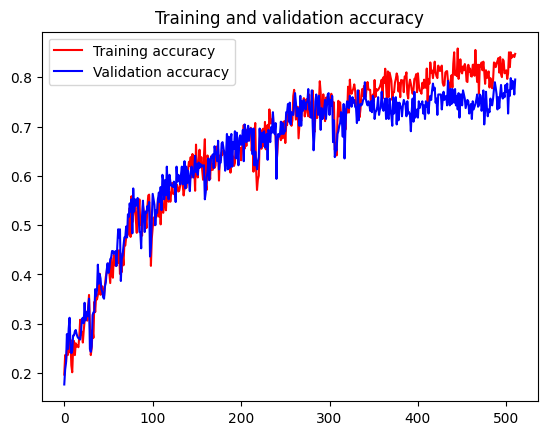

<Figure size 640x480 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

# Model Prediction



In [15]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic'}


4/4 [==============================] - 1s 177ms/step


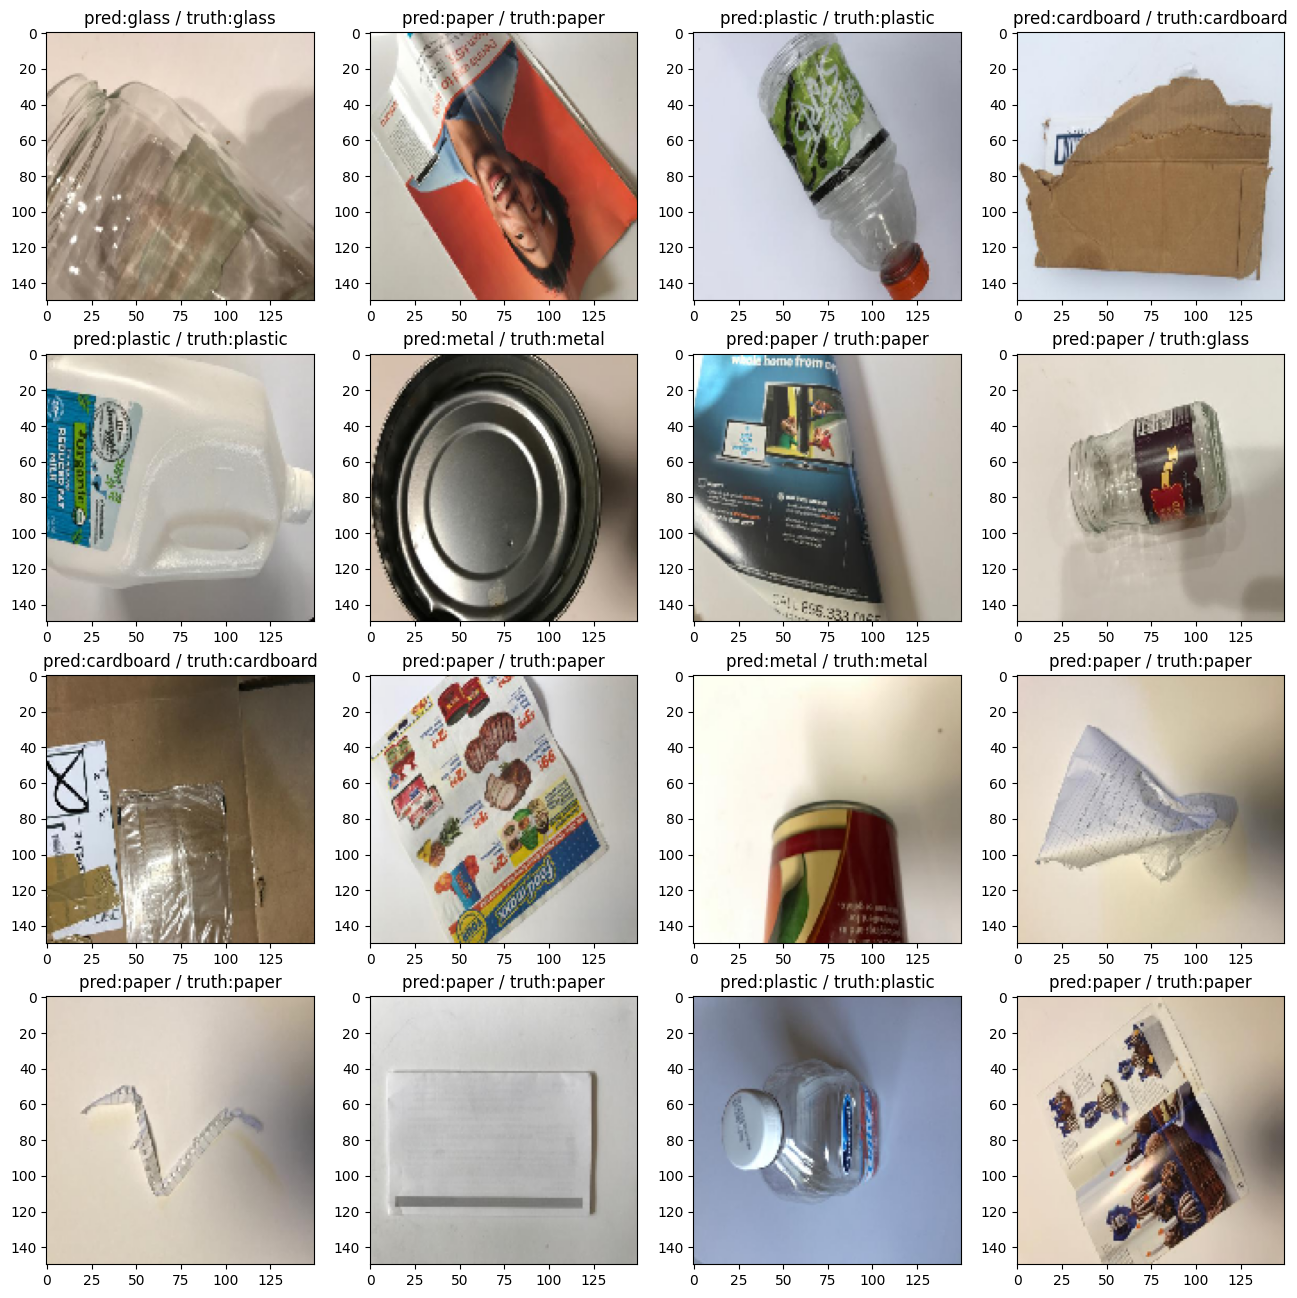

In [18]:
import numpy as np

test_x, test_y = validation_generator.__getitem__(1)

preds = model.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])

In [19]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('my_model.h5')

# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dropout (Dropout)           (None, 82944)             0

## Wrap Up

The model can succesfully predict 15 images correct out of 16 images used in testing